In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-images/train_naip_images/house_5611500170.tif
/kaggle/input/train-images/train_naip_images/house_1555200180.tif
/kaggle/input/train-images/train_naip_images/house_5249804560.tif
/kaggle/input/train-images/train_naip_images/house_925049360.tif
/kaggle/input/train-images/train_naip_images/house_720079001.tif
/kaggle/input/train-images/train_naip_images/house_7128300855.tif
/kaggle/input/train-images/train_naip_images/house_6163901382.tif
/kaggle/input/train-images/train_naip_images/house_4459800100.tif
/kaggle/input/train-images/train_naip_images/house_2425039017.tif
/kaggle/input/train-images/train_naip_images/house_2011400401.tif
/kaggle/input/train-images/train_naip_images/house_2473380400.tif
/kaggle/input/train-images/train_naip_images/house_3905000340.tif
/kaggle/input/train-images/train_naip_images/house_2268000180.tif
/kaggle/input/train-images/train_naip_images/house_8645900080.tif
/kaggle/input/train-images/train_naip_images/house_7956200220.tif
/kaggle/inpu

**TABULAR DATASET MODEL(BASELINE)**

In [19]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
train_df = pd.read_excel("/kaggle/input/cdc-project/traindata_process (1).xlsx")
test_df  = pd.read_excel("/kaggle/input/cdc-project/testdata_process.xlsx")

In [21]:
for df in [train_df, test_df]:
  df["zipcode_offset"] = df["zipcode"] - 98000
  df["lat_long_interaction"] = df["lat"] * df["long"]

In [22]:
important_features = [
    "sqft_living_log_scaled",
    "sqft_living15_log_scaled",
    "sqft_above_log_scaled",
    "sqft_basement_scaled",
    "bedrooms",
    "bathrooms",
    "floors",
    "grade",
    "view",
    "lat",
    "long",
    "house_age_before_sale",
    "lat_long_interaction",
    "sqft_lot_log_scaled",
    "sqft_lot15_log_scaled",
    "waterfront",
    "condition",
    "has_basement",
    "zipcode_offset"
]

In [23]:
X = train_df[important_features]

y = train_df["price_log"]

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_log_list = []
r2_log_list = []
rmse_real_list = []
r2_real_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):

    X_train = X.iloc[train_idx].values
    X_val   = X.iloc[val_idx].values
    y_train = y.iloc[train_idx].values  
    y_val   = y.iloc[val_idx].values

    model = xgb.XGBRegressor(
        n_estimators=2500,
        learning_rate=0.02,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # ---------- LOG SCALE METRICS ----------
    val_pred_log = model.predict(X_val)

    rmse_log = mean_squared_error(y_val, val_pred_log)**0.5
    r2_log   = r2_score(y_val, val_pred_log)

    rmse_log_list.append(rmse_log)
    r2_log_list.append(r2_log)

    # ---------- REAL PRICE METRICS ----------
    val_pred_real = np.expm1(val_pred_log)
    y_val_real    = np.expm1(y_val)

    rmse_real = mean_squared_error(y_val_real, val_pred_real)**0.5
    r2_real   = r2_score(y_val_real, val_pred_real)

    rmse_real_list.append(rmse_real)
    r2_real_list.append(r2_real)

    print(
        f"Fold {fold} | "
        f"RMSE(log): {rmse_log:.4f} | R²(log): {r2_log:.4f} | "
        f"RMSE(real): {rmse_real:.0f} | R²(real): {r2_real:.4f}"
    )

print("\n===== Metrices =====")
print("Mean RMSE (log):", np.mean(rmse_log_list))
print("Mean R² (log):", np.mean(r2_log_list))
print("Mean RMSE (real):", np.mean(rmse_real_list))
print("Mean R² (real):", np.mean(r2_real_list))

Fold 1 | RMSE(log): 0.1632 | R²(log): 0.9034 | RMSE(real): 115155 | R²(real): 0.8943
Fold 2 | RMSE(log): 0.1608 | R²(log): 0.9030 | RMSE(real): 126423 | R²(real): 0.8837
Fold 3 | RMSE(log): 0.1638 | R²(log): 0.9083 | RMSE(real): 127064 | R²(real): 0.8928
Fold 4 | RMSE(log): 0.1649 | R²(log): 0.8996 | RMSE(real): 110765 | R²(real): 0.8974
Fold 5 | RMSE(log): 0.1655 | R²(log): 0.8968 | RMSE(real): 109745 | R²(real): 0.8959

===== Metrices =====
Mean RMSE (log): 0.16366777254092818
Mean R² (log): 0.9022369423423088
Mean RMSE (real): 117830.35888259669
Mean R² (real): 0.8928475508559404


In [26]:
final_model = xgb.XGBRegressor(
    n_estimators=2500,
    learning_rate=0.02,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)

final_model.fit(X.values, y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
X_test = test_df[important_features]
X_test = X_test.apply(pd.to_numeric, errors="coerce")
X_test = X_test.fillna(0)

test_pred_log = final_model.predict(X_test.values)
test_pred_price = np.expm1(test_pred_log)

test_df["predicted_price"] = test_pred_price
save_path = "/kaggle/working/test_predictions.csv"
test_df.to_csv(save_path, index=False)

print("Saved successfully to:", save_path)

Saved successfully to: /kaggle/working/test_predictions.csv


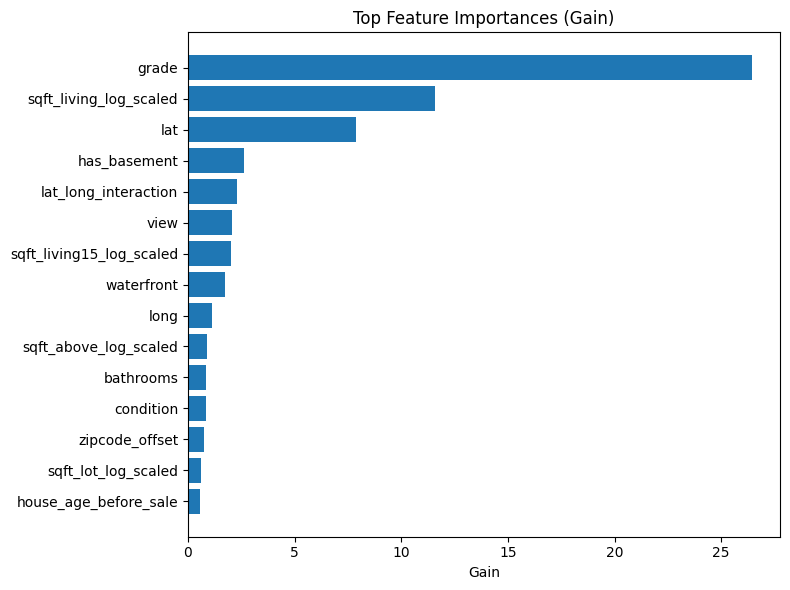

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

importance = final_model.get_booster().get_score(importance_type="gain")

imp_df = (
    pd.DataFrame({
        "feature_idx": importance.keys(),
        "gain": importance.values()
    })
)

imp_df["important_features"] = imp_df["feature_idx"].apply(
    lambda x: important_features[int(x[1:])]
)

imp_df = imp_df.sort_values("gain", ascending=False).head(15)

plt.figure(figsize=(8, 6))
plt.barh(imp_df["important_features"], imp_df["gain"])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

In [29]:
final_model.save_model("xgb_tabular_only.json")

**TABULAR + IMAGES MODEL**

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [31]:
ID_COL = "id"
TARGET = "price_log"

TRAIN_TIF_DIR = "/kaggle/input/train-images/train_naip_images"
TEST_TIF_DIR  = "/kaggle/input/test-images/test_naip_images"

TRAIN_PNG_DIR = "/kaggle/working/train_png"
TEST_PNG_DIR  = "/kaggle/working/test_png"

os.makedirs(TRAIN_PNG_DIR, exist_ok=True)
os.makedirs(TEST_PNG_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [32]:
train_df[ID_COL] = train_df[ID_COL].astype(str)
test_df[ID_COL]  = test_df[ID_COL].astype(str)

In [33]:
# Convert GeoTIFF to PNG
import tifffile as tiff

def geotiff_to_png(tif_path, png_path):
    img = tiff.imread(tif_path)

    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3:
        if img.shape[0] <= 3:
            img = img[:3].transpose(1,2,0)
        else:
            img = img[:,:,:3]

    img = np.nan_to_num(img).astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = (img * 255).astype(np.uint8)

    img = cv2.resize(img, (224,224))
    cv2.imwrite(png_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [34]:
for pid in tqdm(train_df[ID_COL].unique()):
    tif = f"{TRAIN_TIF_DIR}/house_{pid}.tif"
    png = f"{TRAIN_PNG_DIR}/house_{pid}.png"
    if os.path.exists(png) or not os.path.exists(tif):
        continue
    geotiff_to_png(tif, png)

100%|██████████| 16110/16110 [03:01<00:00, 88.65it/s]  


In [35]:
for pid in tqdm(test_df[ID_COL].unique()):
    tif = f"{TEST_TIF_DIR}/house_{pid}.tif"
    png = f"{TEST_PNG_DIR}/house_{pid}.png"
    if os.path.exists(png) or not os.path.exists(tif):
        continue
    geotiff_to_png(tif, png)

100%|██████████| 5396/5396 [01:25<00:00, 62.88it/s]


In [36]:
cnn = models.resnet18(pretrained=False)
cnn.load_state_dict(
    torch.load(
        "/kaggle/input/pytorch/resnet18-f37072fd.pth",
        map_location=device
    )
)

cnn = nn.Sequential(*list(cnn.children())[:-1])  # remove FC
cnn = cnn.to(device)
cnn.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [37]:
img_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

In [38]:
def extract_cnn_embedding(img_path):
    if not os.path.exists(img_path):
        return np.zeros(512)

    img = Image.open(img_path).convert("RGB")
    x = img_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = cnn(x).squeeze().cpu().numpy()

    return emb

In [39]:
def extract_structural_features(img_path):
    feats = {
        "building_density_q75": 0.0,
        "road_density_q75": 0.0,
        "open_space_variance": 0.0,
        "density_balance": 0.0,
        "water_flag": 0
    }

    if not os.path.exists(img_path):
        return feats

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    buildings = ((hsv[:,:,1] < 40) & (gray > 80)).astype(np.float32)
    roads     = ((gray > 100) & (gray < 160)).astype(np.float32)
    water     = ((hsv[:,:,0] > 90) & (hsv[:,:,0] < 130) & (hsv[:,:,1] > 60))

    block = 16  # 14x14 blocks

    def block_density(mask):
        h, w = mask.shape
        densities = []
        for i in range(0, h, block):
            for j in range(0, w, block):
                densities.append(mask[i:i+block, j:j+block].mean())
        return np.array(densities)

    b_blocks = block_density(buildings)
    r_blocks = block_density(roads)

    feats["building_density_q75"] = np.quantile(b_blocks, 0.75)
    feats["road_density_q75"]     = np.quantile(r_blocks, 0.75)
    feats["open_space_variance"]  = (1 - (buildings + roads)).var()
    feats["density_balance"]      = buildings.mean() - roads.mean()
    feats["water_flag"]           = int(water.mean() > 0.01)

    return feats

In [40]:
def add_image_features(df, img_dir, id_col):
    cnn_feats = []
    struct_feats = []

    for pid in tqdm(df[id_col]):
        img_path = f"{img_dir}/house_{pid}.png"
        cnn_feats.append(extract_cnn_embedding(img_path))
        struct_feats.append(extract_structural_features(img_path))

    cnn_df = pd.DataFrame(cnn_feats, columns=[f"cnn_{i}" for i in range(512)])
    struct_df = pd.DataFrame(struct_feats)

    return pd.concat([df.reset_index(drop=True), struct_df, cnn_df], axis=1)

In [41]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [42]:
train_df = add_image_features(train_df, "/kaggle/working/train_png", ID_COL)
val_df   = add_image_features(val_df,   "/kaggle/working/train_png", ID_COL)
test_df  = add_image_features(test_df,  "/kaggle/working/test_png",  ID_COL)

100%|██████████| 5404/5404 [01:05<00:00, 82.49it/s]


In [43]:
cnn_cols = [c for c in train_df.columns if c.startswith("cnn_")]

scaler = StandardScaler()
X_cnn_train = scaler.fit_transform(train_df[cnn_cols])

pca = PCA(n_components=16, random_state=42)
X_cnn_train_pca = pca.fit_transform(X_cnn_train)

cnn_pca_cols = [f"cnn_pca_{i}" for i in range(16)]

train_df[cnn_pca_cols] = X_cnn_train_pca
val_df[cnn_pca_cols]   = pca.transform(scaler.transform(val_df[cnn_cols]))
test_df[cnn_pca_cols]  = pca.transform(scaler.transform(test_df[cnn_cols]))

In [44]:
feature_cols = [
    # tabular
    "sqft_living_log_scaled",
    "sqft_living15_log_scaled",
    "sqft_above_log_scaled",
    "sqft_basement_scaled",
    "bedrooms",
    "bathrooms",
    "floors",
    "grade",
    "view",
    "lat",
    "long",
    "house_age_before_sale",
    "lat_long_interaction",
    "sqft_lot_log_scaled",
    "sqft_lot15_log_scaled",
    "waterfront",
    "condition",
    "has_basement",
    "zipcode_offset",

    # image structural
    "building_density_q75",
    "road_density_q75",
    "open_space_variance",
    "density_balance",
    "water_flag"
] + cnn_pca_cols

In [45]:
print("Train PCA shape:", train_df[cnn_pca_cols].shape)
print("Val PCA shape:", val_df[cnn_pca_cols].shape)
print("Test PCA shape:", test_df[cnn_pca_cols].shape)

Train PCA shape: (12967, 16)
Val PCA shape: (3242, 16)
Test PCA shape: (5404, 16)


In [46]:
model = xgb.XGBRegressor(
    n_estimators=4000,
    learning_rate=0.015,
    max_depth=5,
    min_child_weight=9,
    subsample=0.75,
    colsample_bytree=0.75,
    gamma=0.05,
    reg_alpha=0.1,
    reg_lambda=1.2,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1
)

model.fit(
    train_df[feature_cols],
    train_df["price_log"],
    eval_set=[(val_df[feature_cols], val_df["price_log"])],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.05, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [47]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

log_rmse  = []
log_r2    = []
real_rmse = []
real_r2   = []

y_val_log  = val_df["price_log"].values
y_val_real = np.expm1(y_val_log)

n_estimators = model.n_estimators

# Epoch-wise evaluation
for epoch in range(1, n_estimators + 1):

    y_pred_log = model.predict(
        val_df[feature_cols],
        iteration_range=(0, epoch)
    )

    # ---- LOG SCALE ----
    rmse_l = mean_squared_error(y_val_log, y_pred_log, squared=False)
    r2_l   = r2_score(y_val_log, y_pred_log)

    # ---- REAL SCALE ----
    y_pred_real = np.expm1(y_pred_log)
    rmse_r = mean_squared_error(y_val_real, y_pred_real, squared=False)
    r2_r   = r2_score(y_val_real, y_pred_real)

    log_rmse.append(rmse_l)
    log_r2.append(r2_l)
    real_rmse.append(rmse_r)
    real_r2.append(r2_r)

    if epoch <= 10 or epoch % 50 == 0:
        print(
            f"Epoch {epoch:04d} | "
            f"RMSE(log): {rmse_l:.4f} | R2(log): {r2_l:.4f} | "
            f"RMSE(real): {rmse_r:.0f} | R2(real): {r2_r:.4f}"
        )

Epoch 0001 | RMSE(log): 0.5197 | R2(log): 0.0211 | RMSE(real): 360398 | R2(real): -0.0351
Epoch 0002 | RMSE(log): 0.5156 | R2(log): 0.0365 | RMSE(real): 358624 | R2(real): -0.0249
Epoch 0003 | RMSE(log): 0.5098 | R2(log): 0.0582 | RMSE(real): 356201 | R2(real): -0.0111
Epoch 0004 | RMSE(log): 0.5043 | R2(log): 0.0785 | RMSE(real): 353902 | R2(real): 0.0019
Epoch 0005 | RMSE(log): 0.4987 | R2(log): 0.0988 | RMSE(real): 351564 | R2(real): 0.0151
Epoch 0006 | RMSE(log): 0.4933 | R2(log): 0.1181 | RMSE(real): 349311 | R2(real): 0.0277
Epoch 0007 | RMSE(log): 0.4878 | R2(log): 0.1376 | RMSE(real): 346997 | R2(real): 0.0405
Epoch 0008 | RMSE(log): 0.4825 | R2(log): 0.1563 | RMSE(real): 344762 | R2(real): 0.0528
Epoch 0009 | RMSE(log): 0.4777 | R2(log): 0.1730 | RMSE(real): 342766 | R2(real): 0.0638
Epoch 0010 | RMSE(log): 0.4735 | R2(log): 0.1874 | RMSE(real): 340834 | R2(real): 0.0743
Epoch 0050 | RMSE(log): 0.3276 | R2(log): 0.6110 | RMSE(real): 267756 | R2(real): 0.4287
Epoch 0100 | RMSE(

In [48]:
# ---- Best Epoch ----
best_epoch = np.argmin(log_rmse) + 1

print("\n--- Best Epoch ---")
print(f"Epoch: {best_epoch}")
print(f"RMSE (log):  {log_rmse[best_epoch-1]:.4f}")
print(f"R2   (log):  {log_r2[best_epoch-1]:.4f}")
print(f"RMSE (real): {real_rmse[best_epoch-1]:.0f}")
print(f"R2   (real): {real_r2[best_epoch-1]:.4f}")

# Last epoch

print("\n--- LAST EPOCH ---")
print(f"Epoch: {n_estimators}")
print(f"RMSE (log):  {log_rmse[-1]:.4f}")
print(f"R2   (log):  {log_r2[-1]:.4f}")
print(f"RMSE (real): {real_rmse[-1]:.0f}")
print(f"R2   (real): {real_r2[-1]:.4f}")


--- Best Epoch ---
Epoch: 3493
RMSE (log):  0.1626
R2   (log):  0.9042
RMSE (real): 115847
R2   (real): 0.8931

--- LAST EPOCH ---
Epoch: 4000
RMSE (log):  0.1626
R2   (log):  0.9041
RMSE (real): 115851
R2   (real): 0.8930


<Figure size 1100x800 with 0 Axes>

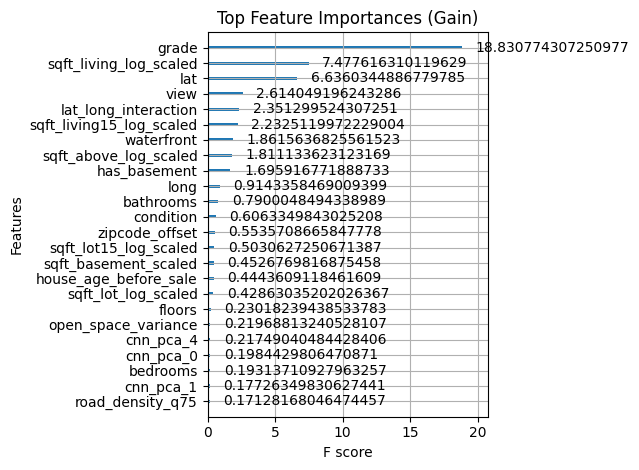

In [49]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(11, 8))
xgb.plot_importance(
    model,
    importance_type="gain", 
    max_num_features=24
)
plt.title("Top Feature Importances (Gain)")
plt.tight_layout()
plt.show()

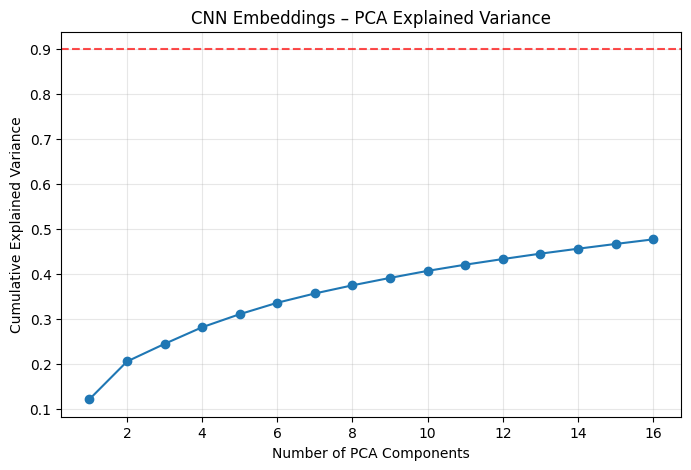

In [50]:
import matplotlib.pyplot as plt
import numpy as np

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.90, linestyle="--", color="red", alpha=0.7)
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("CNN Embeddings – PCA Explained Variance")
plt.grid(alpha=0.3)
plt.show()

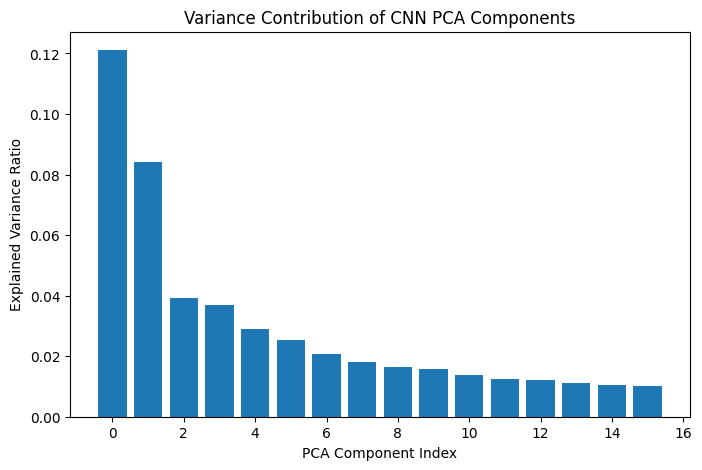

In [51]:
plt.figure(figsize=(8,5))
plt.bar(range(len(explained_var)), explained_var)
plt.xlabel("PCA Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Contribution of CNN PCA Components")
plt.show()

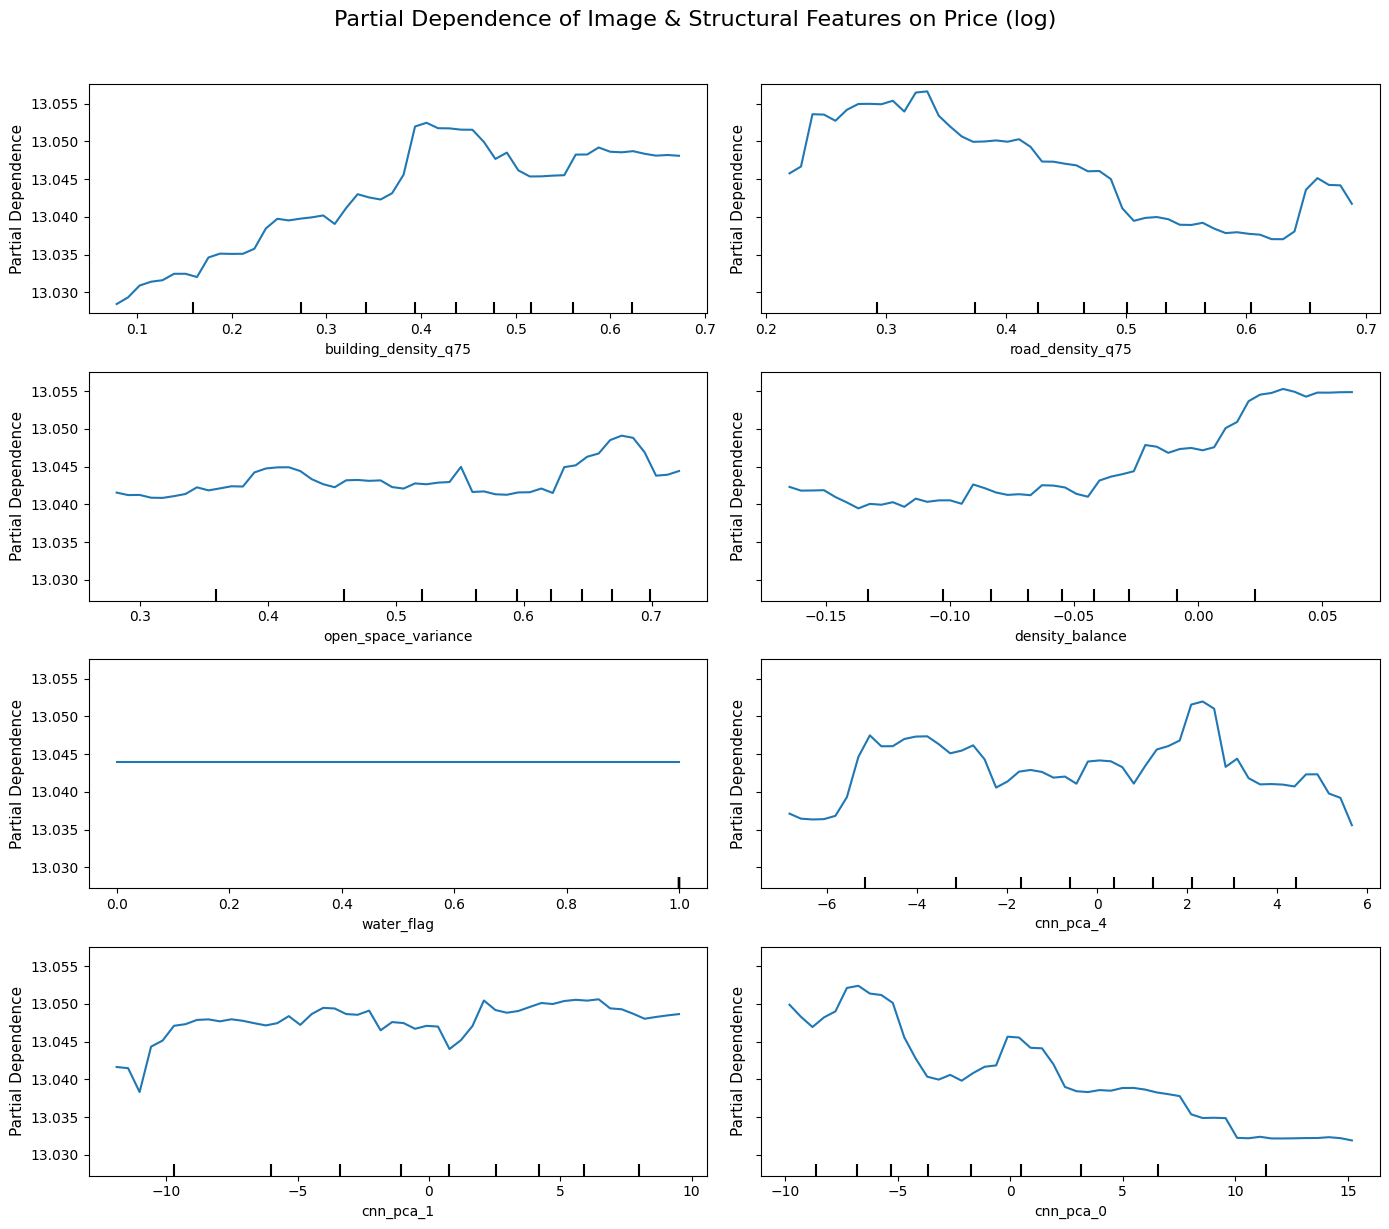

In [52]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = [
    "building_density_q75",
    "road_density_q75",
    "open_space_variance",
    "density_balance",
    "water_flag",
    "cnn_pca_4",
    "cnn_pca_1",
    "cnn_pca_0"
]
fig, ax = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(14, 12)   
)
PartialDependenceDisplay.from_estimator(
    model,
    train_df[feature_cols],
    features=features,
    grid_resolution=50,
    ax=ax
)
for a in ax.flatten():
    a.tick_params(axis="both", labelsize=10)
    a.set_ylabel("Partial Dependence", fontsize=11)

plt.suptitle(
    "Partial Dependence of Image & Structural Features on Price (log)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.show()

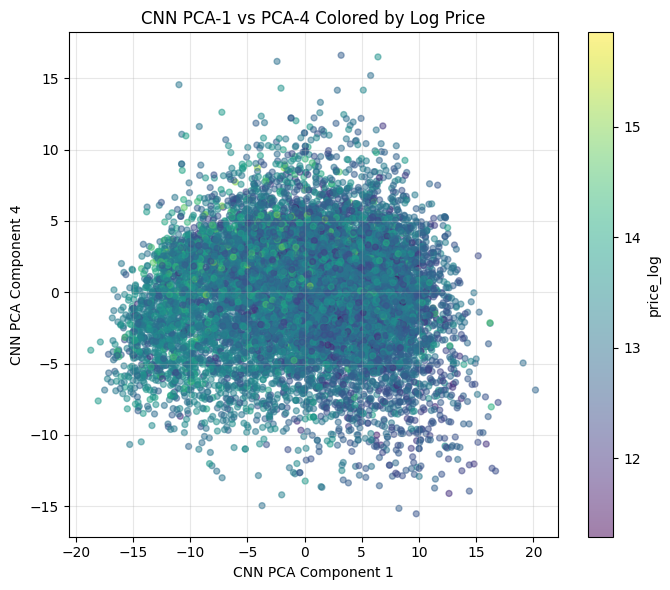

In [53]:
plt.figure(figsize=(7, 6))

sc = plt.scatter(
    train_df["cnn_pca_1"],
    train_df["cnn_pca_4"],
    c=train_df["price_log"],
    cmap="viridis",
    alpha=0.5,
    s=18
)

plt.xlabel("CNN PCA Component 1")
plt.ylabel("CNN PCA Component 4")
plt.title("CNN PCA-1 vs PCA-4 Colored by Log Price")

plt.colorbar(sc, label="price_log")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
img_structural_cols = [
    "building_density_q75",
    "road_density_q75",
    "open_space_variance",
    "density_balance",
    "water_flag"
]
train_df[img_structural_cols].describe()

,building_density_q75,road_density_q75,open_space_variance,density_balance,water_flag
count,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000
mean,0.416571,0.485501,0.559936,-0.055841,0.997224
std,0.173891,0.144789,0.135889,0.075747,0.052619
min,0.000000,0.000000,0.000000,-0.780812,0.000000
25%,0.313477,0.403320,0.493364,-0.092933,1.000000
50%,0.437500,0.500977,0.595053,-0.055046,1.000000
75%,0.536133,0.583008,0.657583,-0.018814,1.000000
max,0.968750,1.000000,0.826671,0.450534,1.000000


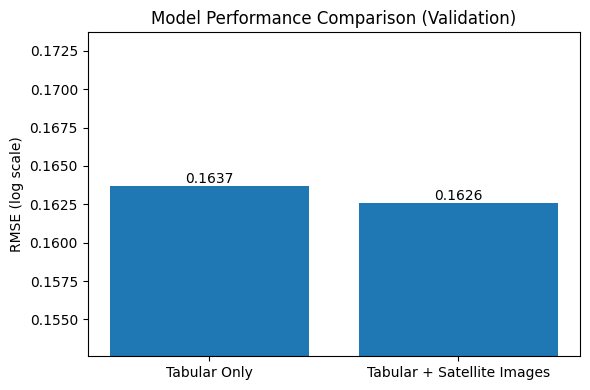

In [64]:
import matplotlib.pyplot as plt

rmse_tabular = 0.1637        # Tabular-only model RMSE (log)
rmse_multimodal = 0.1626     # Tabular + Images model RMSE (log)

labels = ["Tabular Only", "Tabular + Satellite Images"]
rmse_values = [rmse_tabular, rmse_multimodal]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, rmse_values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.4f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylabel("RMSE (log scale)")
plt.title("Model Performance Comparison (Validation)")
plt.ylim(min(rmse_values) - 0.01, max(rmse_values) + 0.01)

plt.tight_layout()
plt.show()

In [56]:
print("Test shape:", test_df.shape)
print("Missing features:", set(feature_cols) - set(test_df.columns))
print("Nulls in test features:")
print(test_df[feature_cols].isna().sum().sum())

Test shape: (5404, 573)
Missing features: set()
Nulls in test features:
0


In [57]:
best_epoch = int(best_epoch) 

test_pred_log = model.predict(
    test_df[feature_cols],
    iteration_range=(0, best_epoch)
)

test_pred_real = np.expm1(test_pred_log)

In [58]:
test_predictions = pd.DataFrame({
    ID_COL: test_df[ID_COL],
    "price_pred": test_pred_real
})

test_predictions.head()

,id,price_pred
0,2591820310,3.706850e+05
1,7974200820,8.665419e+05
2,7701450110,1.127824e+06
3,9522300010,2.032742e+06
4,9510861140,7.031228e+05


In [59]:
test_predictions.to_csv("24113039_final.csv", index=False)

In [60]:
model.save_model("xgb_multimodal.json")

In [61]:
import joblib

joblib.dump(scaler, "cnn_scaler.pkl")
joblib.dump(pca, "cnn_pca.pkl")

['cnn_pca.pkl']

In [62]:
import torch

# Save
torch.save(cnn.state_dict(), "cnn_model.pt")

# Load 
cnn.load_state_dict(torch.load("cnn_model.pt", map_location=device))
cnn.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [63]:
train_df.to_csv("/kaggle/working/train_final.csv", index=False)
test_df.to_csv("/kaggle/working/test_final.csv", index=False)